# Part 1 of project: Denoising Cifar10 via an Autoencoder
# Name: Erjian Guo, Tianyue Xing 
# NetID: eg3097, tx575

In this project, we have two parts: one is denoising autoencoder on black and white pictures: MNIST, the other is denoising color pictures:cifar10.

In part 1, we used CNN to realise autoencoder on Cifar10, and compared results of different combinations and parameters. We designed 6 experiments to compare denoised results from linear/non-linlear activation, numbers of convolutional layers and fully connected layers, subsampling, pooling and dropout.

The main idea of autoencoders is that it has two parts:an encoder and a decoder. Both of them use neural network. The encoder compresses original dimensions of input data. The decoder is inverse process of encoder. There are many ways to build autoencoders in Keras, such as convolutional autoencoders, sequence-to-sequence autoencoders and variational autoencoders.

Reference link:
https://chenrudan.github.io/blog/2016/04/01/dimensionalityreduction.html
https://blog.csdn.net/deephub/article/details/106991939
https://blog.csdn.net/weijifen000/article/details/89440987
https://zhuanlan.zhihu.com/p/33722444
https://www.jeremyjordan.me/autoencoders/
https://zhuanlan.zhihu.com/p/73421413
https://github.com/sdrangan/introml/blob/master/unit10_cnn/demo5_autoencoder.ipynb

Firstly, we load packages and Cifar10 datas. We add some Guass Noise into pictures.

In [1]:
#Load some common packages
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Dropout
from keras.layers.normalization import BatchNormalization


In [2]:
# Use MNIST data as experiment dataset, and rescale the input Xtr and Xts from 0 to 1
from keras.datasets import cifar10
(Xtr, _), (Xts, _) = cifar10.load_data()
Xtr = Xtr[10000:]
Xts = Xts[1000:2000]
#(Xtr,ytr),(Xts,yts) = tf.keras.datasets.mnist.load_data()
Xtr = np.reshape(Xtr, (len(Xtr), 32, 32, 3))
Xtr = Xtr/255
Xts = np.reshape(Xts, (len(Xts), 32, 32, 3))
Xts = Xts/255

#Add some synthetic noise to training and test data
Xtr_noisy = Xtr + 0.15 * np.random.normal(loc=0.0, scale=1.0, size=Xtr.shape) 
Xts_noisy = Xts + 0.15 * np.random.normal(loc=0.0, scale=1.0, size=Xts.shape) 


Xtr_noisy = np.clip(Xtr_noisy, 0., 1.) 
Xts_noisy = np.clip(Xts_noisy, 0., 1.)

Xtr.shape

(40000, 32, 32, 3)

Experiment 1: construct a  auto-encoder with 2 convolution layer encoder (linear activation) and two convolution 
layer decoder (linear activation)

In [3]:
# clear the session.
K.clear_session()

#Set the input size
MN_input = Input(shape=(32,32,3))
# 2 convolution layer encoder each followed by a maxpooling layer 
X_linear = Conv2D(16, (3,3), activation='linear', padding='same')(MN_input)
X_linear = MaxPool2D((2,2), padding='same')(X_linear)
X_linear = BatchNormalization()(X_linear)

X_linear = Conv2D(32, (3,3), activation='linear', padding='same')(X_linear)
X_linear= MaxPool2D((2,2), padding='same', name='encoded_layer')(X_linear)
X_linear = BatchNormalization()(X_linear)


# 2 convolution layer decoder, each followed by a upsampling layer,
X_linear = Conv2D(32, (3, 3), activation='linear', padding='same')(X_linear)
X_linear = UpSampling2D((2, 2))(X_linear)
X_linear = BatchNormalization()(X_linear)

X_linear = Conv2D(16, (3, 3), activation='linear', padding='same')(X_linear)
X_linear = UpSampling2D((2, 2))(X_linear)
X_linear = BatchNormalization()(X_linear)

MN_decode = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(X_linear)
MN_autoencoder = Model(MN_input, MN_decode)

#print the autoencoder mode summary
MN_autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 32)         

In [4]:
# Select the optimizer and loss function(here learning rate lr =0.01)
opt = optimizers.Adam(lr=0.01)
# COmpile the model
MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
#
hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=128,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))

Epoch 1/10
313/313 [==============================] - 54s 172ms/step - loss: 0.0096 - accuracy: 0.6870 - val_loss: 0.0078 - val_accuracy: 0.6781
Epoch 2/10
313/313 [==============================] - 53s 170ms/step - loss: 0.0062 - accuracy: 0.7325 - val_loss: 0.0058 - val_accuracy: 0.7327
Epoch 3/10
313/313 [==============================] - 58s 186ms/step - loss: 0.0058 - accuracy: 0.7384 - val_loss: 0.0071 - val_accuracy: 0.7418
Epoch 4/10
313/313 [==============================] - 56s 178ms/step - loss: 0.0055 - accuracy: 0.7420 - val_loss: 0.0055 - val_accuracy: 0.6999
Epoch 5/10
313/313 [==============================] - 52s 167ms/step - loss: 0.0054 - accuracy: 0.7421 - val_loss: 0.0052 - val_accuracy: 0.7207
Epoch 6/10
313/313 [==============================] - 51s 163ms/step - loss: 0.0052 - accuracy: 0.7442 - val_loss: 0.0052 - val_accuracy: 0.7304
Epoch 7/10
313/313 [==============================] - 50s 160ms/step - loss: 0.0052 - accuracy: 0.7450 - val_loss: 0.0055 - val_ac

In [5]:
def plot_image(Nrow, Ncol, image_size, channel, *image_list):
    plt.figure(figsize=(2*Ncol, 2*Nrow))
    for i in range(1,Ncol+1):
        for j in range(len(image_list)):
            ax = plt.subplot(len(image_list), Ncol, i+j*Ncol)
            plt.imshow(image_list[j][i].reshape(image_size, image_size, channel))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

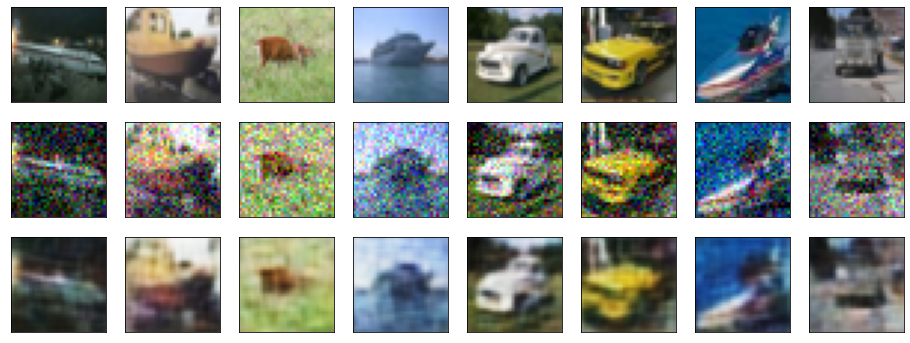

In [6]:
# Display the predict image after using autoencoder
MN_decoded_im1 = MN_autoencoder.predict(Xts_noisy)
plot_image(3, 8, 32, 3, Xts, Xts_noisy, MN_decoded_im1)


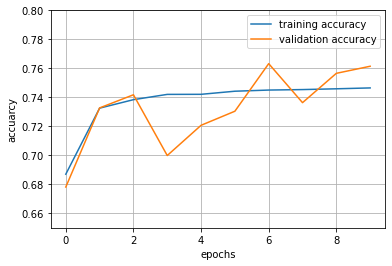

In [9]:
training_acc1 = hist.history['accuracy']
val_acc1 = hist.history['val_accuracy']

plt.plot(training_acc1)
plt.plot(val_acc1)
plt.grid()
plt.ylim(0.65,0.8)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

Experiment 2: construct a  auto-encoder with 2 convolution layer encoder (non-linear activation) and two convolution layer decoder (non-linear activation)

In [10]:
# clear the session.
K.clear_session()
# Set the input size
MN_input = Input(shape=(32,32,3))

#2 convolution layer encoder each followed by a maxpooling layer 
X_non = Conv2D(16, (3,3), activation='relu', padding='same')(MN_input)
X_non = MaxPool2D((2,2), padding='same')(X_non)
X_non = BatchNormalization()(X_non)

X_non = Conv2D(32, (3,3), activation='relu', padding='same')(X_non)
X_non= MaxPool2D((2,2), padding='same', name='encoded_layer')(X_non)
X_non = BatchNormalization()(X_non)

#2 convolution layer decoder, each followed by a upsampling layer,
X_non = Conv2D(32, (3, 3), activation='relu', padding='same')(X_non)
X_non = UpSampling2D((2, 2))(X_non)
X_non = BatchNormalization()(X_non)

X_non = Conv2D(16, (3, 3), activation='relu', padding='same')(X_non)
X_non = UpSampling2D((2, 2))(X_non)
X_non = BatchNormalization()(X_non)

MN_decode = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(X_non)
MN_autoencoder = Model(MN_input, MN_decode)

#print the autoencoder mode summary
MN_autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 32)         

In [11]:
# Select the optimizer and loss function(here learning rate lr =0.01)
opt = optimizers.Adam(lr=0.01)
# COmpile the model
MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
#fit the model
hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=128,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))

Epoch 1/10
313/313 [==============================] - 57s 182ms/step - loss: 0.0088 - accuracy: 0.6797 - val_loss: 0.0070 - val_accuracy: 0.7356
Epoch 2/10
313/313 [==============================] - 55s 174ms/step - loss: 0.0054 - accuracy: 0.7286 - val_loss: 0.0059 - val_accuracy: 0.7301
Epoch 3/10
313/313 [==============================] - 59s 188ms/step - loss: 0.0049 - accuracy: 0.7374 - val_loss: 0.0050 - val_accuracy: 0.7555
Epoch 4/10
313/313 [==============================] - 60s 190ms/step - loss: 0.0047 - accuracy: 0.7416 - val_loss: 0.0046 - val_accuracy: 0.7597
Epoch 5/10
313/313 [==============================] - 55s 175ms/step - loss: 0.0045 - accuracy: 0.7443 - val_loss: 0.0048 - val_accuracy: 0.7522
Epoch 6/10
313/313 [==============================] - 56s 179ms/step - loss: 0.0044 - accuracy: 0.7455 - val_loss: 0.0043 - val_accuracy: 0.7376
Epoch 7/10
313/313 [==============================] - 55s 177ms/step - loss: 0.0043 - accuracy: 0.7457 - val_loss: 0.0043 - val_ac

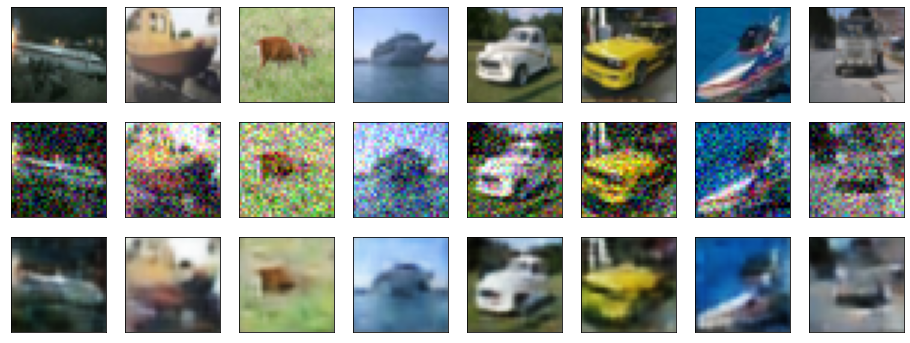

In [12]:
# Display predict images after using autoencoder
MN_decoded_im2 = MN_autoencoder.predict(Xts_noisy)
plot_image(3, 8, 32,3, Xts, Xts_noisy, MN_decoded_im2)

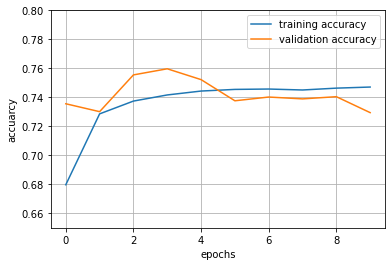

In [13]:
#plot the accuracy 
training_acc2 = hist.history['accuracy']
val_acc2 = hist.history['val_accuracy']

plt.plot(training_acc2)
plt.plot(val_acc2)
plt.grid()
plt.ylim(0.65,0.80)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

Experiment 3: construct one convolution layer followed by one denselayer encoder and one convolution layer followed by one denselayer decoder

In [14]:
# clear the session.
K.clear_session()
# Set the input size
MN_input = Input(shape=(32,32,3))

#one convolution layer followed by one denselayer encoder
X_mix = Conv2D(16, (3,3), activation='linear', padding='same')(MN_input)
X_mix = MaxPool2D((2,2), padding='same')(X_mix)
X_mix = BatchNormalization()(X_mix)

X_mix = Dense(32, activation='relu')(X_mix)
X_mix= MaxPool2D((2,2), padding='same', name='encoded_layer')(X_mix)
X_mix = BatchNormalization()(X_mix)

# one convolution layer followed by one denselayer decoder
X_mix = Dense(32, activation='relu')(X_mix)
X_mix = UpSampling2D((2, 2))(X_mix)
X_mix = BatchNormalization()(X_mix)

X_mix = Conv2D(16, (3, 3), activation='linear', padding='same')(X_mix)
X_mix = UpSampling2D((2, 2))(X_mix)
X_mix = BatchNormalization()(X_mix)

MN_decode = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(X_mix)
MN_autoencoder = Model(MN_input, MN_decode)

#print the autoencoder mode summary
MN_autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16)        64        
_________________________________________________________________
dense (Dense)                (None, 16, 16, 32)        544       
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 32)         

In [15]:
# Select the optimizer and loss function(here learning rate lr =0.01)
opt = optimizers.Adam(lr=0.01)
# COmpile the model
MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
#
hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=128,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))

Epoch 1/10
313/313 [==============================] - 47s 151ms/step - loss: 0.0093 - accuracy: 0.6871 - val_loss: 0.0109 - val_accuracy: 0.7235
Epoch 2/10
313/313 [==============================] - 48s 152ms/step - loss: 0.0065 - accuracy: 0.7244 - val_loss: 0.0065 - val_accuracy: 0.7090
Epoch 3/10
313/313 [==============================] - 46s 148ms/step - loss: 0.0060 - accuracy: 0.7316 - val_loss: 0.0061 - val_accuracy: 0.6676
Epoch 4/10
313/313 [==============================] - 49s 155ms/step - loss: 0.0058 - accuracy: 0.7355 - val_loss: 0.0059 - val_accuracy: 0.7087
Epoch 5/10
313/313 [==============================] - 47s 151ms/step - loss: 0.0056 - accuracy: 0.7387 - val_loss: 0.0057 - val_accuracy: 0.6898
Epoch 6/10
313/313 [==============================] - 46s 147ms/step - loss: 0.0055 - accuracy: 0.7405 - val_loss: 0.0058 - val_accuracy: 0.7015
Epoch 7/10
313/313 [==============================] - 43s 138ms/step - loss: 0.0055 - accuracy: 0.7411 - val_loss: 0.0057 - val_ac

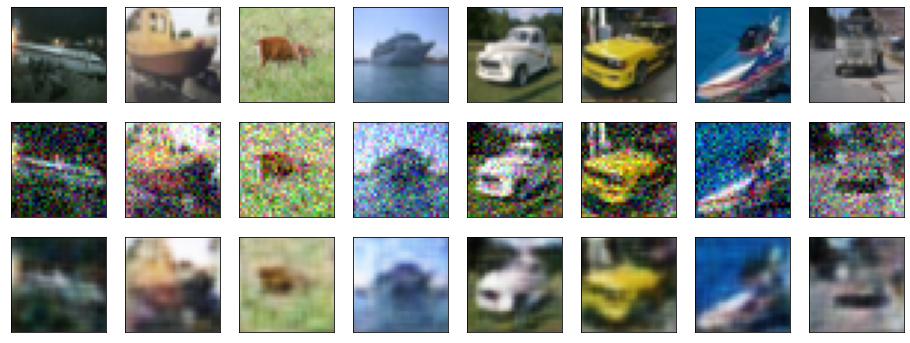

In [16]:
# Display the predict image after using autoencoder
MN_decoded_im3 = MN_autoencoder.predict(Xts_noisy)
plot_image(3, 8, 32,3, Xts, Xts_noisy, MN_decoded_im3)

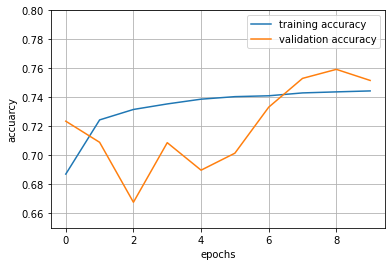

In [17]:
training_acc3 = hist.history['accuracy']
val_acc3 = hist.history['val_accuracy']

plt.plot(training_acc3)
plt.plot(val_acc3)
plt.grid()
plt.ylim(0.65,0.8)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

Experiment 4: no use maxpool, upsampling, batchnomalization and dropout layers

In [18]:
# clear the session.
K.clear_session()
# Set the input size
MN_input = Input(shape=(32,32,3))

#one convolution layer followed by one dense layer encoder
X_no = Conv2D(16, (3,3), activation='linear', padding='same')(MN_input)
X_no = Dense(32, activation='relu')(X_no)

# one convolution layer followed by one dense layer decoder
X_no = Dense(32, activation='relu')(X_no)
X_no = Conv2D(16, (3, 3), activation='linear', padding='same')(X_no)

MN_decode = Dense(3, activation='sigmoid')(X_no)
MN_autoencoder = Model(MN_input, MN_decode)

#print the autoencoder mode summary
MN_autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
dense (Dense)                (None, 32, 32, 32)        544       
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 32)        1056      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
dense_2 (Dense)              (None, 32, 32, 3)         51        
Total params: 6,723
Trainable params: 6,723
Non-trainable params: 0
____________________________________________________

In [19]:
# Select the optimizer and loss function(here learning rate lr =0.01)
opt = optimizers.Adam(lr=0.01)
# COmpile the model
MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
#
hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=128,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))

Epoch 1/10
313/313 [==============================] - 36s 115ms/step - loss: 0.0058 - accuracy: 0.6870 - val_loss: 0.0035 - val_accuracy: 0.7045
Epoch 2/10
313/313 [==============================] - 34s 107ms/step - loss: 0.0034 - accuracy: 0.7175 - val_loss: 0.0034 - val_accuracy: 0.7383
Epoch 3/10
313/313 [==============================] - 37s 119ms/step - loss: 0.0032 - accuracy: 0.7233 - val_loss: 0.0032 - val_accuracy: 0.7334
Epoch 4/10
313/313 [==============================] - 35s 111ms/step - loss: 0.0032 - accuracy: 0.7238 - val_loss: 0.0031 - val_accuracy: 0.7344
Epoch 5/10
313/313 [==============================] - 33s 105ms/step - loss: 0.0031 - accuracy: 0.7248 - val_loss: 0.0031 - val_accuracy: 0.7257
Epoch 6/10
313/313 [==============================] - 32s 103ms/step - loss: 0.0031 - accuracy: 0.7259 - val_loss: 0.0030 - val_accuracy: 0.7280
Epoch 7/10
313/313 [==============================] - 32s 103ms/step - loss: 0.0031 - accuracy: 0.7271 - val_loss: 0.0030 - val_ac

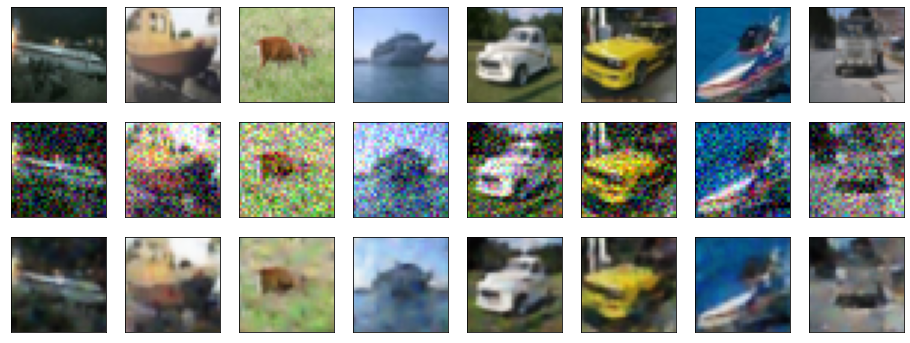

In [20]:
# Display the predict image after using autoencoder
MN_decoded_im4 = MN_autoencoder.predict(Xts_noisy)
plot_image(3, 8, 32, 3,Xts, Xts_noisy, MN_decoded_im4)

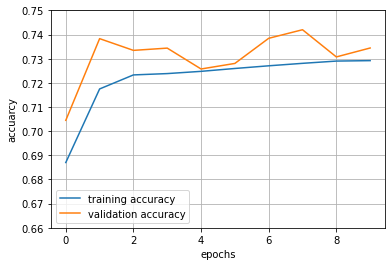

In [21]:
training_acc4 = hist.history['accuracy']
val_acc4 = hist.history['val_accuracy']

plt.plot(training_acc4)
plt.plot(val_acc4)
plt.grid()
plt.ylim(0.66,0.75)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

Experiment 5:increase the number of layers in encoder and decoder

In [24]:
# clear the session.
K.clear_session()
# Set the input size
MN_input = Input(shape=(32,32,3))

#2 convolution layers followed by 2 dense layers encoder
X_inc = Conv2D(32, (3,3), activation='linear', padding='same')(MN_input)
X_inc = Conv2D(16, (3,3), activation='linear', padding='same')(X_inc)
X_inc = Dense(8, activation='relu')(X_inc)
X_inc = Dense(4, activation='relu')(X_inc)

# 2 convolution layers followed by 2 dense layers decoder
X_inc = Dense(4, activation='relu')(X_inc)
X_inc = Dense(8, activation='relu')(X_inc)
X_inc = Conv2D(16, (3, 3), activation='linear', padding='same')(X_inc)
X_inc = Conv2D(32, (3, 3), activation='linear', padding='same')(X_inc)

MN_decode = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(X_inc)
MN_autoencoder = Model(MN_input, MN_decode)

#print the autoencoder mode summary
MN_autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
dense (Dense)                (None, 32, 32, 8)         136       
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 4)         36        
_________________________________________________________________
dense_2 (Dense)              (None, 32, 32, 4)         20        
_________________________________________________________________
dense_3 (Dense)              (None, 32, 32, 8)        

In [25]:
# Select the optimizer and loss function(here learning rate lr =0.01)
opt = optimizers.Adam(lr=0.01)
# COmpile the model
MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
#
hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=128,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))

Epoch 1/10
313/313 [==============================] - 73s 235ms/step - loss: 0.0110 - accuracy: 0.4533 - val_loss: 0.0111 - val_accuracy: 0.4337
Epoch 2/10
313/313 [==============================] - 66s 210ms/step - loss: 0.0090 - accuracy: 0.4588 - val_loss: 0.0088 - val_accuracy: 0.4195
Epoch 3/10
313/313 [==============================] - 63s 201ms/step - loss: 0.0082 - accuracy: 0.4511 - val_loss: 0.0085 - val_accuracy: 0.4697
Epoch 4/10
313/313 [==============================] - 68s 218ms/step - loss: 0.0080 - accuracy: 0.4570 - val_loss: 0.0082 - val_accuracy: 0.4558
Epoch 5/10
313/313 [==============================] - 69s 220ms/step - loss: 0.0063 - accuracy: 0.5681 - val_loss: 0.0048 - val_accuracy: 0.6208
Epoch 6/10
313/313 [==============================] - 66s 211ms/step - loss: 0.0048 - accuracy: 0.6283 - val_loss: 0.0044 - val_accuracy: 0.6439
Epoch 7/10
313/313 [==============================] - 68s 218ms/step - loss: 0.0042 - accuracy: 0.6454 - val_loss: 0.0051 - val_ac

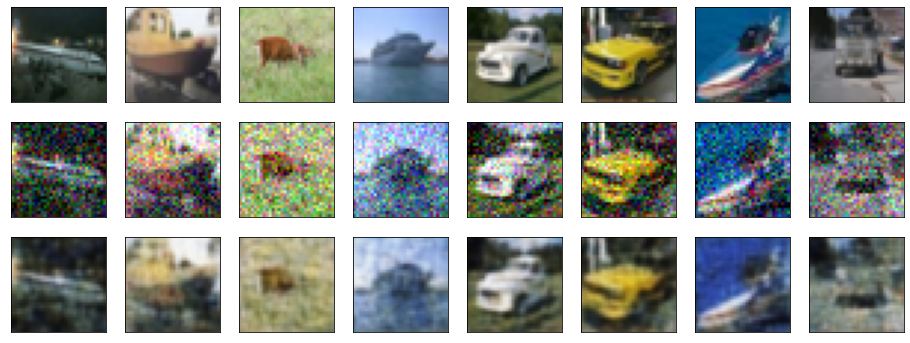

In [29]:
# Display the predict image after using autoencoder
MN_decoded_im5 = MN_autoencoder.predict(Xts_noisy)
plot_image(3, 8, 32,3, Xts, Xts_noisy, MN_decoded_im5)

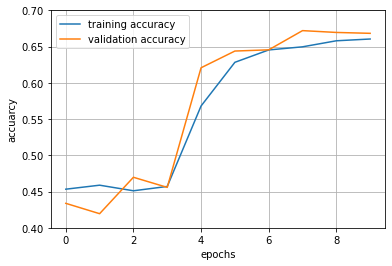

In [30]:
training_acc5 = hist.history['accuracy']
val_acc5 = hist.history['val_accuracy']

plt.plot(training_acc5)
plt.plot(val_acc5)
plt.grid()
plt.ylim(0.4,0.67)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

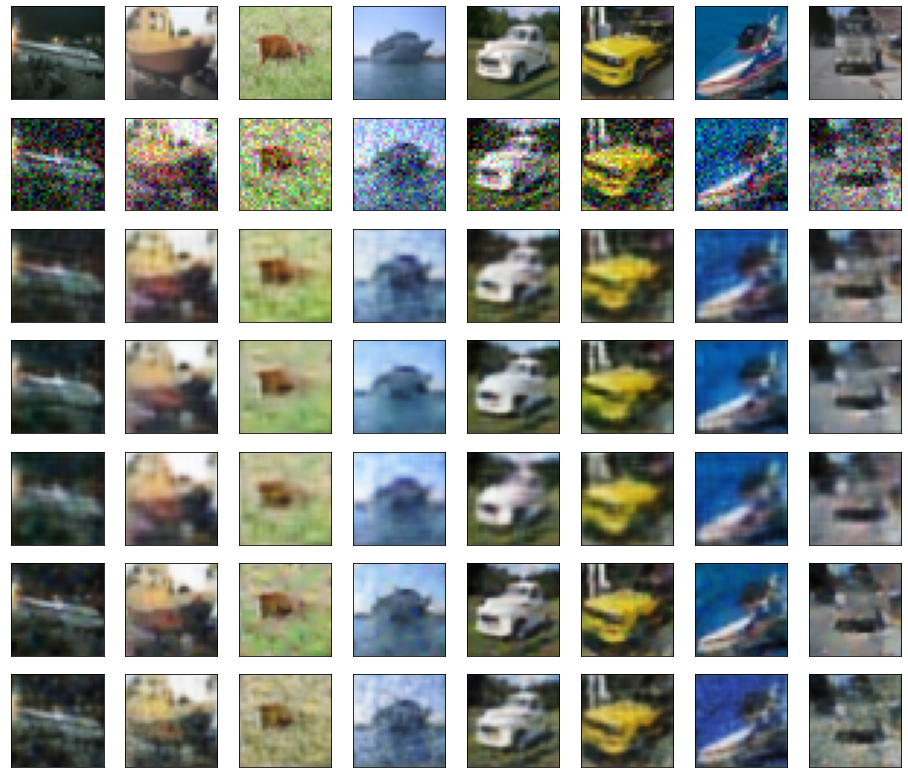

In [32]:
# plot the predict images of all experiments 
plot_image(7,8,32,3 , Xts, Xts_noisy, MN_decoded_im1,MN_decoded_im2,MN_decoded_im3,MN_decoded_im4,MN_decoded_im5)

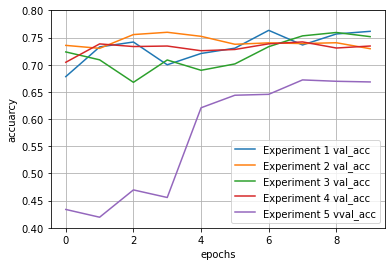

In [33]:
# plot the accuracy of all experiments 
plt.plot(val_acc1)
plt.plot(val_acc2)
plt.plot(val_acc3)
plt.plot(val_acc4)
plt.plot(val_acc5)
plt.grid()
plt.ylim(0.4,0.8)
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['Experiment 1 val_acc ','Experiment 2 val_acc ','Experiment 3 val_acc ','Experiment 4 val_acc ','Experiment 5 vval_acc'])

In [36]:
rates = [0.01,0.001,0.0001]
batch_size = 128
loss_hist = []

# TODO
for l in rates:
        
    # Clear the session
    K.clear_session()

   # Set the input size
    MN_input = Input(shape=(32,32,3))

    #one convolution layer followed by one dense layer encoder
    X_non = Conv2D(32, (3,3), activation='linear', padding='same')(MN_input)
    X_non = Dense(64, activation='relu')(X_non)

    # one convolution layer followed by one dense layer decoder
    X_non = Dense(64, activation='relu')(X_non)
    X_non = Conv2D(32, (3, 3), activation='linear', padding='same')(X_non)

    MN_decode = Dense(3, activation='sigmoid')(X_non)
    MN_autoencoder = Model(MN_input, MN_decode)
    
    # Select the optimizer and loss function(here learning rate lr =0.01)
    opt = optimizers.Adam(lr=l)
    # COmpile the model
    MN_autoencoder.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])
 
        
    # Fit the model    
    hist = MN_autoencoder.fit(Xtr_noisy, Xtr,
                epochs=10,
                batch_size=batch_size,
                shuffle=True
                , validation_data=(Xts_noisy,Xts))    
    
    # Save the loss history
    loss_hist.append( hist.history['loss'])
    
    # Print the final accuracy
    val_acc = hist.history['val_accuracy'][-1]
    print("lr=%12.4e test accuracy=%f" % (l, val_acc))

Epoch 1/10
313/313 [==============================] - 65s 209ms/step - loss: 0.0061 - accuracy: 0.6881 - val_loss: 0.0033 - val_accuracy: 0.7185
Epoch 2/10
313/313 [==============================] - 59s 187ms/step - loss: 0.0033 - accuracy: 0.7220 - val_loss: 0.0031 - val_accuracy: 0.7356
Epoch 3/10
313/313 [==============================] - 57s 181ms/step - loss: 0.0031 - accuracy: 0.7264 - val_loss: 0.0030 - val_accuracy: 0.7353
Epoch 4/10
313/313 [==============================] - 57s 183ms/step - loss: 0.0030 - accuracy: 0.7275 - val_loss: 0.0030 - val_accuracy: 0.7335
Epoch 5/10
313/313 [==============================] - 57s 181ms/step - loss: 0.0030 - accuracy: 0.7292 - val_loss: 0.0030 - val_accuracy: 0.7346
Epoch 6/10
313/313 [==============================] - 56s 180ms/step - loss: 0.0030 - accuracy: 0.7299 - val_loss: 0.0031 - val_accuracy: 0.7464
Epoch 7/10
313/313 [==============================] - 57s 182ms/step - loss: 0.0029 - accuracy: 0.7298 - val_loss: 0.0029 - val_ac

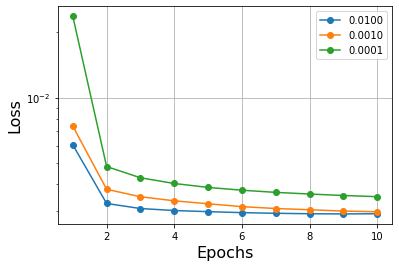

In [37]:
ntest = len(loss_hist)
ntr = 10
batch_size=128
for it, loss in enumerate(loss_hist):
    
    nepochs = len(loss)
    epochs = np.arange(1,nepochs+1)
    plt.semilogy(epochs, loss, 'o-')

    rate_str = ['{0:5.4f}'.format(lr) for lr in rates]

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(rate_str,loc='upper right')
plt.grid()

Conclution: The denoised results of non-linear activattion are better than results of linear. More convolutional layers has better performance. Pooling and dropout can reduce dimensions but less accuracy.